# Python Routine for reading RIGOL oscilloscope and plot MCP counts

## Import python packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import oskar
# scripts = oskar.Scripts()
import numpy as np
from tqdm import tqdm
import numpy
import matplotlib.pyplot as plot
import sys
import pickle as pkl
# import pyvisa as visa
import visa
import datetime
from scipy.optimize import curve_fit
from collections import defaultdict
from scipy.stats import kurtosis, skew
import pandas as pd
import xarray as xr
from collections import OrderedDict
from pathlib import Path
import fnmatch

In [2]:
# front = np.array([-300,-200,-100,0,+100,+200,+300,+400])
# counts = np.array([1.1,1.6,2.4,4.4,9.2,30,58,110])
# plt.plot(front, counts, 'o-', label="Countrate (10s bins)"
#          "\n"
#          "MCP gain constant: 2kV"
#          "\n"
#          "Grid has no effect (Contant): 300V")
# plt.ylabel('Countrate (s$^{-1}$)')
# plt.xlabel('Voltage on front plate (V)')
# plt.title('Voltage leakeage vs Dark counts')
# # plt.yscale('log')
# plt.legend(loc=0)
# plt.savefig('MCP_DarkCounts.png',dpi=150)

## Define pulse-detection function

In [3]:
def count(ydata,min_level,min_width,dt,deadtime):
    '''
    Input: raw ydata, a trigger level as min_level, a minimum width as min_width, a deadtime as deadtime, and sampling rate as dt
    Returns: an array of the time stamp of the rising edge of each pulses
    '''
    ignore = int(deadtime/dt)
    min_x = min_width / dt
    threshold = ydata < min_level
    threshold[0] = False
    threshold[-1] = False
    rngs = np.where(np.diff(threshold))[0].reshape(-1, 2) # reshape into an array of the rising edge and falling edge of the pulses
    delete_index = []
    for i in range(len(rngs)):
        k = rngs[i]
        if i == 0:
            tmp = k[0]
        
        if tmp < k[0] < tmp+ignore:
            delete_index.append(i)
        else:
            tmp = k[0]
    rngs = np.delete(rngs,delete_index,axis=0)    
    pulse = rngs[rngs[:,1]-rngs[:,0] > min_x]
    return pulse[:,0]

# # Problem1: this will miss some pulses if the second pulse sits close to the ringings of the first pulse
# # Problem2: if deadtime > min_width, this will make the min_width filtering useless
# def count(ydata,min_level,min_width,dt,deadtime):
#     '''
#     Input: raw ydata, a trigger level as min_level, a minimum width as min_width, a deadtime as deadtime, and sampling rate as dt
#     Returns: an array of the time stamp of the rising edge of each pulses
#     '''
#     ignore = int(deadtime/dt)
#     min_x = min_width / dt
#     threshold = ydata > min_level
#     for k in np.argwhere(threshold).flatten():
#         threshold[k:k+ignore]=True
#     threshold[0] = False
#     threshold[-1] = False
#     rngs = np.where(np.diff(threshold))[0].reshape(-1, 2) # reshape into an array of the rising edge and falling edge of the pulses
#     pulse = rngs[rngs[:,1]-rngs[:,0] > min_x]
#     return pulse[:,0]

In [4]:
os.getcwd()

'/home/electron/Documents'

## Read off and save data from RIGOL 100MHz oscilloscope

In [30]:
acq_times = int(1e4) # 'Record this many waveforms'
datalength = 600 # number of datapoints per waveform
min_level = -0.002 # minimum threshold/ trigger level (V)
min_width = 2E-9 # minimum pulse width (s)
deadtime = 20E-9 # detection deadtime in (s)

U2 = -1 # U2 value
Prf = -5 # rf power (dBm), "-50" if off
Tload = 100E-6 # load time (s)
Twait = 500E-9 # wait time (s)
Tej = 400E-9 # ejection pulse width (s)
Additional_info = '_'


data_folder = '/home/electron/Documents/electron_notebooks/two-layer'+'/'+'data'
# data_folder = r'C:\\Users\\qyu51\\Documents\\electron\\readoutoscilloscope'+'/'+'data'
date = datetime.datetime.today().strftime("%Y%m%d")
save_folder = data_folder +'/'+ date
if os.path.exists(save_folder) == False:
    Path(save_folder).mkdir(parents=True, exist_ok=False)
    os.chdir(save_folder)
else:
    os.chdir(save_folder)

In [31]:
# datarrray=np.zeros([acq_times, datalength])
rm = visa.ResourceManager()
instruments = rm.list_resources()
usb = list(filter(lambda x: 'USB' in x, instruments))
if len(usb) != 1:
    print('Bad instrument list', instruments)
    sys.exit(-1)
# scope = rm.open_resource(usb[0], timeout=20, chunk_size=1024000)
scope = rm.open_resource(usb[0])
voltscale = float(scope.query(':CHAN1:SCAL?'))
voltoffset = float(scope.query(":CHAN1:OFFS?"))
timescale = float(scope.query(":TIM:SCAL?"))
time = numpy.linspace(0,12 * timescale, num=datalength) # time list
dt = time[1]-time[0] # time step
time_range = time[-1]-time[0]
pulses = np.array([]) 

for i in tqdm(np.arange(0,acq_times,1)):
    scope.write(":WAV:DATA? CHAN1") #Request the data
    rawdata = scope.read_raw() #Read the block of data
    scope.write(":KEY:FORCE")
    rawdata = rawdata[10 : ] #Drop the heading
    data = numpy.frombuffer(rawdata, 'B')
    data = data * -1 + 255
    data = (data - 130.0 - voltoffset/voltscale*25) / 25 * voltscale
    pulses = numpy.append(pulses, count(data,min_level,min_width,dt,deadtime))

scope.close()
runID = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
print('runID:',runID)
filename = runID + '_histogram_U2_' + str("{:.2f}".format(U2))+ '_Prf' + str("{:.2f}".format(Prf)) +'dBm_Tload' + str("{:n}".format(Tload/1E-6)) + 'us_Twait' \
    + str("{:n}".format(Twait/1E-6)) + 'us_Tej' + str("{:n}".format(Tej/1E-9)) + 'ns_reps'+ \
    str("{:.1e}".format(acq_times)) +'_trigger' + str("{:.2f}".format(min_level))+ Additional_info
np.savetxt(filename+ '.txt',pulses*dt,delimiter=',')
np.save(filename + '.npy',pulses*dt)

100%|██████████| 10000/10000 [00:29<00:00, 343.84it/s]

runID: 20220630_184352


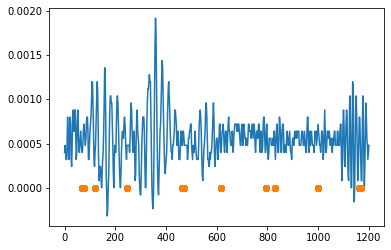

In [32]:
plt.plot(time*1e9,data)
plt.plot(pulses*dt*1e9,np.zeros(len(pulses)),'o')

In [33]:
pulses

array([414., 414., 414., 414., 414., 414., 414., 414., 414., 414., 414.,
       414., 414.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,  35.,
        35.,  35.,  35.,  38.,  38.,  38.,  38.,  38.,  38.,  38.,  38.,
        38.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
        59., 499., 499., 499., 499., 499., 499., 499., 499., 499., 396.,
       396., 396., 396., 396., 396., 396., 396., 396., 396., 396., 396.,
       396., 396., 396., 583., 583., 583., 583., 583., 583., 583., 583.,
       583., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123.,
       123.,  36.,  36.,  36.,  36.,  36.,  36.,  36.,  36.,  36., 307.,
       307., 307., 307., 307., 307., 307., 307., 307., 307., 307., 307.,
       307., 307., 235., 235., 235., 235., 235., 235., 235., 235., 235.,
       235., 235., 235., 235., 580., 580., 580., 580., 580., 580., 580.,
       580., 580., 580., 580., 580., 580., 231., 231., 231., 231., 231.,
       231., 231., 231.])

(0.0, 1000.0)

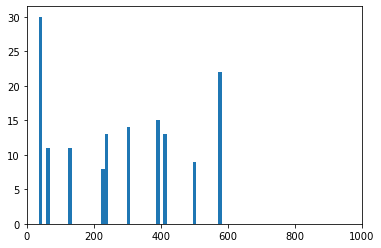

In [36]:
plt.hist(pulses, bins = 50)
plt.xlim(0,1000)

## Plotting the histogram given a list of runID

In [29]:
# Import data
data_folder = '/home/electron/Documents/electron_notebooks/two-layer'+'/'+'data'
# data_folder = r'C:\\Users\\qyu51\\Documents\\electron\\readoutoscilloscope'+'/'+'data'
# date = datetime.datetime.today().strftime("%Y%m%d")
date = str(20220617)
save_folder = data_folder +'/'+ date
if os.path.exists(save_folder) == False:
    Path(save_folder).mkdir(parents=True, exist_ok=False)
    os.chdir(save_folder)
else:
    os.chdir(save_folder)

In [236]:
runID_list = ['20220617_170005','20220617_170008','20220617_170012','20220617_170018','20220617_170023',] # pulses 2,3,4,5,6,7,8,9
labels = ['U2 = -2.5, RF = -5dBm','U2 = +1.0, RF = -5dBm','U2 = +1.0, RF = OFF','U2 = +1.0, RF = OFF','Extraction OFF, U2 = -2.5, RF = -5dBm',]

runID_list = runID_list[0:4]
labels = labels[0:4]
for runID in runID_list:
    for file in os.listdir('.'):
        if fnmatch.fnmatch(file, '*'+runID+'*.npy'):
            print(file)
            pulses_loaded = np.load(file)
#             print(pulses_loaded)
    if runID == runID_list[0]:
        df = pd.DataFrame(pulses_loaded*1e9,columns=[runID])
    else:
        df1 = pd.DataFrame(pulses_loaded*1e9,columns=[runID])
#         df.merge(df1,how='left',left_on='index', right_on='index1')
        df = pd.concat([df,df1],join='outer',axis=1,sort=False).reset_index()
        df.drop('index', inplace=True, axis=1)
    
df

pulses220220617_170005_RIGOL_MCP_pulses.npy
pulses320220617_170008_RIGOL_MCP_pulses.npy
pulses420220617_170012_RIGOL_MCP_pulses.npy
pulses520220617_170018_RIGOL_MCP_pulses.npy


,20220617_170005,20220617_170008,20220617_170012,20220617_170018
0,174.290484,425.709516,145.24207,169.282137
1,174.290484,425.709516,145.24207,169.282137
2,174.290484,425.709516,145.24207,169.282137
3,174.290484,425.709516,145.24207,169.282137
4,174.290484,425.709516,145.24207,169.282137
...,...,...,...,...
1634,427.712855,NaN,NaN,NaN
1635,169.282137,NaN,NaN,NaN
1636,427.712855,NaN,NaN,NaN
1637,169.282137,NaN,NaN,NaN


Text(0.5, 1.0, 'MCP Pulses Histogram\n')

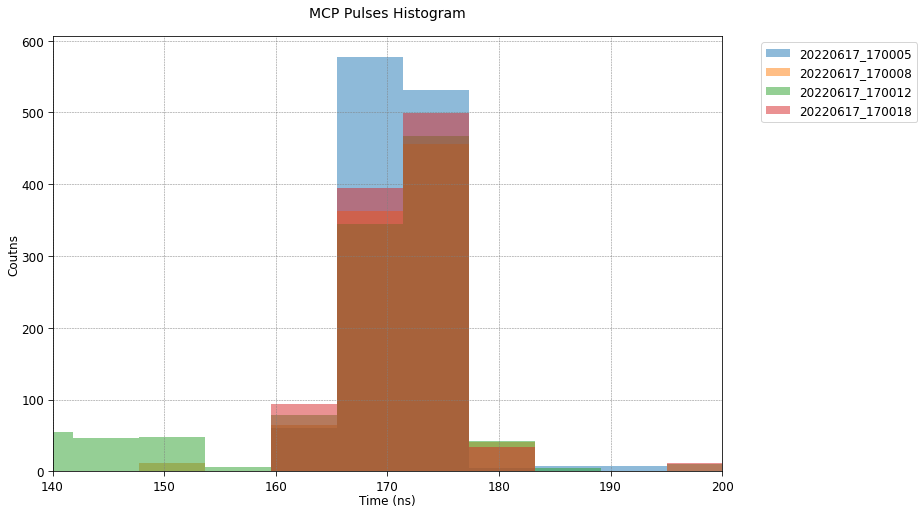

In [228]:
# Plotting in a single plot
ax = df.plot.hist(alpha=0.5,bins=int(datalength/6),figsize = (12,8),fontsize=12)
ax.legend(bbox_to_anchor =(1.3, 1),fontsize=12)
ax.grid()
ax.set_xlabel("Time (ns)",fontdict={'size': 12})
ax.set_ylabel("Coutns",fontdict={'size': 12})
ax.set_xlim(140,200)
ax.set_title("MCP Pulses Histogram\n",fontdict={'size': 14})

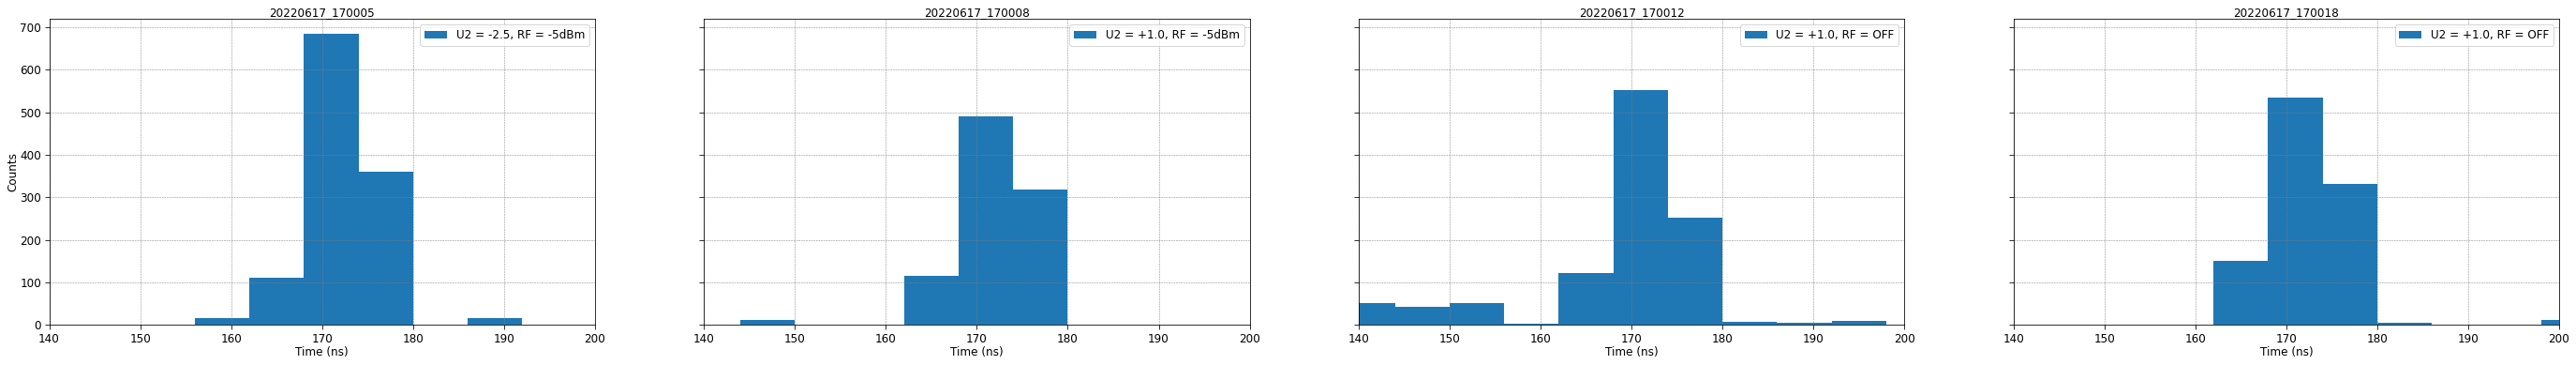

In [233]:
# Plotting in different subplots
m = 1# number of rows of the subplots 
n = 4# number of column of the subplots

params = {   "font.size":12,
             'axes.labelsize': 12,
             'axes.titlesize':12,
             'xtick.major.size':5,
             'ytick.major.size':5,
             'ytick.minor.size':5,
             'xtick.labelsize':12,
             'ytick.labelsize':12,
             "lines.linewidth": 1, 
             'lines.markersize':2,
             'axes.titlepad': 1,
             'axes.labelpad': 1,
             'legend.fontsize':5,
             "grid.color": "0.5",    # gray gridlines
             "grid.linestyle": '--',  # solid gridlines
             "grid.linewidth": 0.5,  # thin gridlines
    }


fig, axes = plt.subplots(m, n,sharey=True,sharex=True,figsize=(8*n,4*m))
plt.rcParams.update(params)
plts = []
xmin = 140
xmax = 200
# time_range = 600e-9
bins = np.arange(0, 600, 6, dtype=int)
# bins = np.arange(0, int(time_range*1e9), 6, dtype=int)
# bins = int(datalength/6)
for i in range(m):
    for j in range(n):
        if m == 1:
            plts.append(axes[j].hist(df[runID_list[i*m+j]], bins=bins, alpha = 1,label = labels[i*m+j]))
            axes[j].legend(fontsize=12)
            axes[j].set_title(runID_list[i*m+j])
            axes[j].set_xlim(xmin,xmax)
            axes[j].grid()
        else:
            plts.append(axes[i,j].hist(df[runID_list[i*m+j]], bins=bins, alpha = 1,label =labels[i*m+j]))
            axes[i,j].legend(fontsize=12)
            axes[i,j].set_title(runID_list[i*m+j])
            axes[i,j].set_xlim(xmin,xmax)
            axes[i,j].grid()
for i in range(n):
    if m == 1:
        axes[i].set_xlabel("Time (ns)",fontdict={'size': 12})
    else:
        axes[m-1,i].set_xlabel("Time (ns)",fontdict={'size': 12})
for i in range(m):
    if m == 1:
        axes[0].set_ylabel("Counts",fontdict={'size': 12})
    else:
        axes[i,0].set_ylabel("Counts",fontdict={'size': 12})

plt.rcParams.update(params)
plt.show()



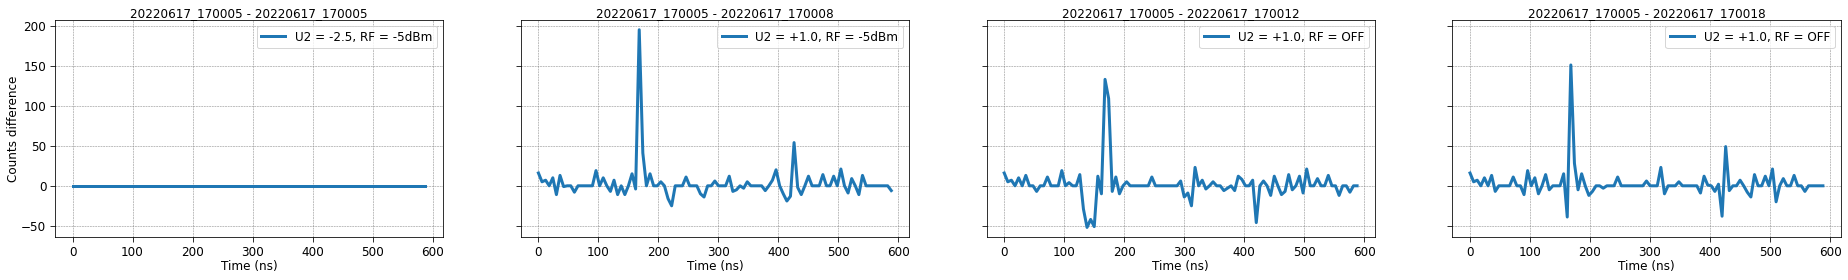

In [239]:
# Plotting the difference of the subplots
row_index = 0 # row index of the signal data
column_index = 0 # column index of the signal data

params = {   "font.size":12,
             'axes.labelsize': 12,
             'axes.titlesize':12,
             'xtick.major.size':5,
             'ytick.major.size':5,
             'ytick.minor.size':5,
             'xtick.labelsize':12,
             'ytick.labelsize':12,
             "lines.linewidth": 3, 
             'lines.markersize':2,
             'axes.titlepad': 1,
             'axes.labelpad': 1,
             'legend.fontsize':5,
             "grid.color": "0.5",    # gray gridlines
             "grid.linestyle": '--',  # solid gridlines
             "grid.linewidth": 0.5,  # thin gridlines
    }

fig, axes_difference = plt.subplots(m, n,sharey=True,sharex=True,figsize=(8*n,4*m))
plt.rcParams.update(params)
for i in range(m):
    for j in range(n):
        if m == 1:
            axes_difference[j].plot(plts[row_index*m+column_index][1][:-1],plts[row_index*m+column_index][0]-plts[i*m+j][0],label=labels[i*m+j])
            axes_difference[j].legend(fontsize=12)
            axes_difference[j].set_title(runID_list[row_index*m+column_index]+' - '+runID_list[i*m+j])
            axes_difference[j].grid()
        else:
            axes_difference[i,j].plot(plts[row_index*m+column_index][1][:-1],plts[row_index*m+column_index][0]-plts[i*m+j][0],label=labels[i*m+j])
            axes_difference[i,j].legend(fontsize=12)
            axes_difference[i,j].set_title(runID_list[row_index*m+column_index]+' - '+runID_list[i*m+j])
            axes_difference[i,j].grid()
for i in range(n):
    if m == 1:
        axes_difference[i].set_xlabel("Time (ns)",fontdict={'size': 12})
    else:
        axes_difference[m-1,i].set_xlabel("Time (ns)",fontdict={'size': 12})
for i in range(m):
    if m == 1:
        axes_difference[0].set_ylabel("Counts difference",fontdict={'size': 12})
    else:
        axes_difference[i,0].set_ylabel("Counts difference",fontdict={'size': 12})

plt.rcParams.update(params)
plt.show()

# plt.plot(a[0]-b[0])

## 0617 plotting

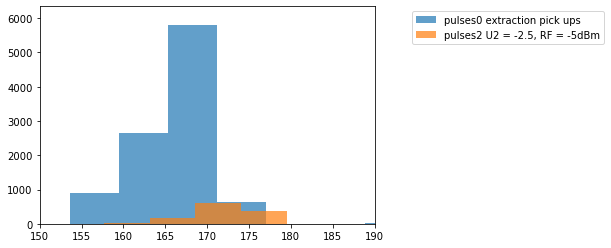

In [163]:
pulses0 = pulses # pulses 0 trigger level 0.01V to look at the pickup of the ejection pulse
# pulses1 = pulses # pulses 1 scope input = AWG output positive extraction pulse
# pulses2 = pulses
# pulses3 = pulses
# pulses4 = pulses
# pulses5 = pulses
# pulses6 = pulses
# pulses7 = pulses
# pulses8 = pulses
# pulses9 = pulses
z = plt.hist(pulses0*dt*1e9, bins=100, alpha = 0.7, label ='pulses0 extraction pick ups'); # pulses2 U2 = -2.5, RF = -5dBm
a = plt.hist(pulses2*dt*1e9, bins=100, alpha = 0.7, label ='pulses2 U2 = -2.5, RF = -5dBm'); # pulses2 U2 = -2.5, RF = -5dBm

# b = plt.hist(pulses3*dt*1e9, bins=100, alpha = 0.7, label ='pulses3 U2 = +1.0, RF = -5dBm'); # pulses3 U2 = +1.0, RF = -5dBm
# c = plt.hist(pulses4*dt*1e9, bins=100, alpha = 0.7, label ='pulses4 U2 = +1.0, RF = OFF'); # pulses4 U2 = +1.0, RF = OFF
# d = plt.hist(pulses5*dt*1e9, bins=100, alpha = 0.7, label ='pulses5 U2 = -2.5, RF = OFF'); # pulses5 U2 = +1.0, RF = OFF
# e = plt.hist(pulses6*dt*1e9, bins=100, alpha = 0.7, label ='pulses6 Extraction OFF, U2 = -2.5, RF = -5dBm'); # pulses6 Extraction OFF, U2 = -2.5, RF = -5dBm
# f = plt.hist(pulses7*dt*1e9, bins=100, alpha = 0.7, label ='pulses7 Extraction OFF, U2 = +1.0, RF = -5dBm'); # pulses7 Extraction OFF, U2 = +1.0, RF = -5dBm
# g = plt.hist(pulses8*dt*1e9, bins=100, alpha = 0.7, label ='pulses8 Extraction OFF, U2 = +1.0, RF = OFF'); # pulses8 Extraction OFF, U2 = +1.0, RF = OFF
# h = plt.hist(pulses9*dt*1e9, bins=100, alpha = 0.7, label ='pulses9 Extraction OFF, U2 = -2.5, RF = OFF'); # pulses9 Extraction OFF, U2 = +1.0, RF = OFF
plt.xlim(150,190)
plt.legend(bbox_to_anchor=(1.7, 1))

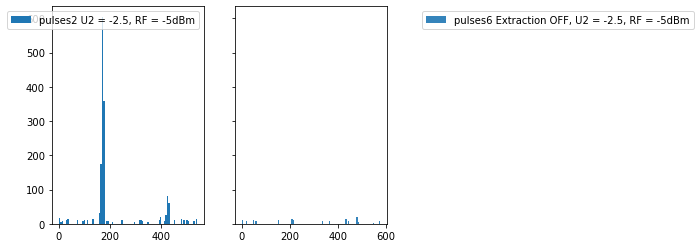

In [117]:
# pulses2 = pulses
# pulses3 = pulses
# pulses4 = pulses
# pulses5 = pulses
# pulses6 = pulses
# pulses7 = pulses
# pulses8 = pulses
# pulses9 = pulses

# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# plt.subplots(1, 1)
fig, axes = plt.subplots(1, 2,sharey=True)

# df1.hist('a', ax=axes[0])
# df2.hist('b', ax=axes[1])

# plt.show()
axes[0].hist(pulses2*dt*1e9, bins=100, alpha = 1,label ='pulses2 U2 = -2.5, RF = -5dBm'); # pulses2 U2 = -2.5, RF = -5dBm
# b = plt.hist(pulses3*dt*1e9, bins=100, alpha = 0.7, label ='pulses3 U2 = +1.0, RF = -5dBm'); # pulses3 U2 = +1.0, RF = -5dBm
# c = plt.hist(pulses4*dt*1e9, bins=100, alpha = 0.7, label ='pulses4 U2 = +1.0, RF = OFF'); # pulses4 U2 = +1.0, RF = OFF
# d = plt.hist(pulses5*dt*1e9, bins=100, alpha = 0.7, label ='pulses5 U2 = -2.5, RF = OFF'); # pulses5 U2 = +1.0, RF = OFF
# plt.subplots(1, 2)
axes[0].legend()
axes[1].hist(pulses6*dt*1e9, bins=100, alpha = 0.9,label ='pulses6 Extraction OFF, U2 = -2.5, RF = -5dBm'); # pulses6 Extraction OFF, U2 = -2.5, RF = -5dBm
# f = plt.hist(pulses7*dt*1e9, bins=100, alpha = 0.7, label ='pulses7 Extraction OFF, U2 = +1.0, RF = -5dBm'); # pulses7 Extraction OFF, U2 = +1.0, RF = -5dBm
# g = plt.hist(pulses8*dt*1e9, bins=100, alpha = 0.7, label ='pulses8 Extraction OFF, U2 = +1.0, RF = OFF'); # pulses8 Extraction OFF, U2 = +1.0, RF = OFF
# h = plt.hist(pulses9*dt*1e9, bins=100, alpha = 0.7, label ='pulses9 Extraction OFF, U2 = -2.5, RF = OFF'); # pulses9 Extraction OFF, U2 = +1.0, RF = OFF
plt.legend(bbox_to_anchor=(3.05, 1))
plt.show()

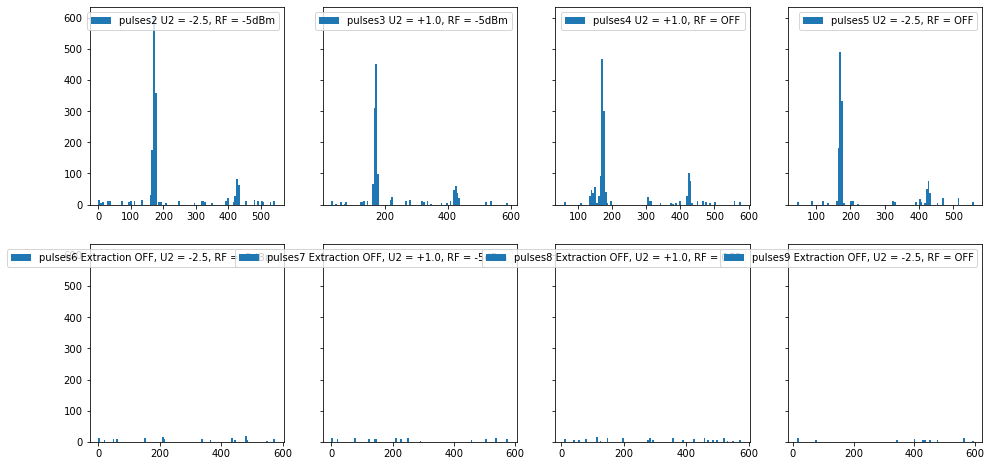

In [146]:
fig, axes = plt.subplots(2, 4,sharey=True,figsize=(16,8))

axes[0,0].hist(pulses2*dt*1e9, bins=100, label ='pulses2 U2 = -2.5, RF = -5dBm'); # pulses2 U2 = -2.5, RF = -5dBm
axes[0,0].legend()
axes[0,1].hist(pulses3*dt*1e9, bins=100,  label ='pulses3 U2 = +1.0, RF = -5dBm'); # pulses3 U2 = +1.0, RF = -5dBm
axes[0,1].legend()
axes[0,2].hist(pulses4*dt*1e9, bins=100,  label ='pulses4 U2 = +1.0, RF = OFF'); # pulses4 U2 = +1.0, RF = OFF
axes[0,2].legend()
axes[0,3].hist(pulses5*dt*1e9, bins=100,  label ='pulses5 U2 = -2.5, RF = OFF'); # pulses5 U2 = +1.0, RF = OFF
axes[0,3].legend()
axes[1,0].hist(pulses6*dt*1e9, bins=100,  label ='pulses6 Extraction OFF, U2 = -2.5, RF = -5dBm'); # pulses6 Extraction OFF, U2 = -2.5, RF = -5dBm
axes[1,0].legend()
axes[1,1].hist(pulses7*dt*1e9, bins=100,  label ='pulses7 Extraction OFF, U2 = +1.0, RF = -5dBm'); # pulses7 Extraction OFF, U2 = +1.0, RF = -5dBm
axes[1,1].legend()
axes[1,2].hist(pulses8*dt*1e9, bins=100,  label ='pulses8 Extraction OFF, U2 = +1.0, RF = OFF'); # pulses8 Extraction OFF, U2 = +1.0, RF = OFF
axes[1,2].legend()
axes[1,3].hist(pulses9*dt*1e9, bins=100,  label ='pulses9 Extraction OFF, U2 = -2.5, RF = OFF'); # pulses9 Extraction OFF, U2 = +1.0, RF = OFF
axes[1,3].legend()
# axes[2,0].plot(axes[0,0]-axes[0,1])
# axes[2,0].hist((pulses2-pulses2)*dt*1e9, bins=100,  label ='pulses2-pulses2'); # pulses6 Extraction OFF, U2 = -2.5, RF = -5dBm
# axes[2,0].legend()
# axes[2,1].hist((pulses2-pulses3)*dt*1e9, bins=100,  label ='pulses2-pulses3'); # pulses7 Extraction OFF, U2 = +1.0, RF = -5dBm
# axes[2,1].legend()
# axes[2,2].hist((pulses2-pulses4)*dt*1e9, bins=100,  label ='pulses2-pulses4'); # pulses8 Extraction OFF, U2 = +1.0, RF = OFF
# axes[2,2].legend()
# axes[2,3].hist((pulses2-pulses5)*dt*1e9, bins=100,  label ='pulses2-pulses5'); # pulses9 Extraction OFF, U2 = +1.0, RF = OFF
# axes[2,3].legend()
# plt.legend(bbox_to_anchor=(3.05, 1))
plt.show()

(0.0, 50.0)

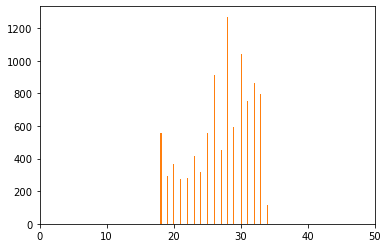

In [151]:
plt.hist(pulses1*dt*1e9, bins=100, label ='extraction pulse'); # real extraction pulse
plt.hist(pulses1*dt*1e9, bins=100, label ='extraction pulse'); # real extraction pulse
plt.xlim(0,50)

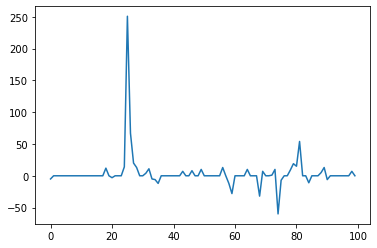

In [38]:
plt.plot(a[0]-b[0])

## Record Run ID and save data

In [ ]:
# os.getcwd()
data_folder = '/home/electron/Documents/electron_notebooks/two-layer'+'/'+'data'
date = datetime.datetime.today().strftime("%Y%m%d")
save_folder = data_folder +'/'+ date
runID = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
print('runID:',runID)
filename = runID + '_histogram_U2_' + str("{:.2f}".format(U2))+ '_Prf' + str("{:.2f}".format(Prf)) +'dBm_Tload' + str("{:n}".format(Tload/1E-6)) + 'us_Twait' \
    + str("{:n}".format(Twait/1E-6)) + 'us_Tej' + str("{:n}".format(Tej/1E-9)) + 'ns_reps'+ \
    str("{:.1e}".format(acq_times)) +'_trigger' + str("{:.2f}".format(min_level))+ Additional_info + '.txt'
if os.path.exists(save_folder) == False:
    Path(save_folder).mkdir(parents=True, exist_ok=False)
    os.chdir(save_folder)
else:
    os.chdir(save_folder)
np.savetxt(filename,pulses*dt,delimiter=',')

In [133]:
i = 1
runID = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
pulses_time = pulses1*dt
print(runID)
np.savetxt('pulses'+str(i)+'_%s_RIGOL_MCP_pulses.dat'%(runID),pulses_time)
np.save('pulses'+str(i)+'_%s_RIGOL_MCP_pulses.npy'%(runID),pulses_time)

20220617_172812


In [166]:
i = 1
runID= '20220617_172812'
pulses_loaded = np.load('pulses'+str(i)+'_%s_RIGOL_MCP_pulses.npy'%(runID))

In [21]:
runID = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
pulses_time = pulses*dt
print(runID)
np.savetxt('%s_darkcounts_ion.dat'%(runID),pulses_time)
np.save('%s_darkcounts_ion.npy'%(runID),pulses_time)

20220617_163141


## Import Data if necessary

In [3]:
'before shootoff, with ion: 20190517_115706, 20190517_122253, 20190517_125640'
'No ion, before shootoff: 20190517_132900'
'Ion at 325F (very hot): 20190517_172354, 20190517_173036, 20190517_174554'

'Ion at 325F (very hot): 20190517_172354, 20190517_173036, 20190517_174554'

In [74]:
runID= '20220616_165438'
# pulses_time = np.loadtxt('%s_darkcounts_ion.dat'%(runID))

pulses_time = np.load('%s_darkcounts_ion.npy'%(runID))

In [71]:
len(pulses_time)

120

(array([2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1.,
        1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1.,
        1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1.,
        1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 2.,
        1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2.]),
 array([8.81469115e-05, 3.26544240e-04, 5.64941569e-04, 8.03338898e-04,
        1.04173623e-03, 1.28013356e-03, 1.51853088e-03, 1.75692821e-03,
        1.99532554e-03, 2.23372287e-03, 2.47212020e-03, 2.71051753e-03,
        2.94891486e-03, 3.18731219e-03, 3.42570952e-03, 3.66410684e-03,
        3.90250417e-03, 4.14090150e-03, 4.37929883e-03, 4.61769616e-03,
        4.85609349e-03, 5.09449082e-03, 5.33288815e-03, 5.57128548e-03,
        5.80968280e-03, 6.04808013e-03, 6.28647746e-03, 6.52487479e-03,
        6.76327212e-03, 7.00166945e-03, 7.2400

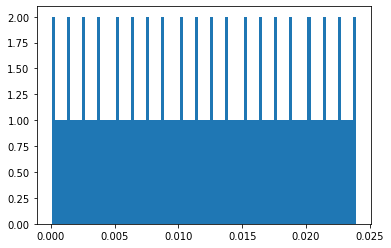

In [63]:
plt.hist(pulses_time, bins =100)

In [57]:
# np.save('%s_563K_before_Shootoff_truncated.npy'%(runID),pulses_time)

## Bin data to plot countrates

In [64]:
#bin size
ratTime = 5000e-6

# pulses_time = pulses_time[:-10000]
bins = int((pulses_time[-1]-pulses_time[0])/ratTime)
ratesy, ratesx = np.histogram(pulses_time, bins=bins)
rates = ratesy/ratTime
# rates = rates[:int(30/ratTime)]
np.savetxt('%s_darkcounts_ion_per%.2gs.dat'%(runID,ratTime),rates)

In [65]:
def rebinDat(ratTime,pulses_time):
    bins = int((pulses_time[-1]-pulses_time[0])/ratTime)
    ratesy, ratesx = np.histogram(pulses_time, bins=bins)
    rates = ratesy/ratTime
    return ratesy, ratesx, rates

In [66]:
def moving_average(x, w):
    'define moving average function'
    return np.convolve(x, np.ones(w), 'valid') / w

## Plot rates

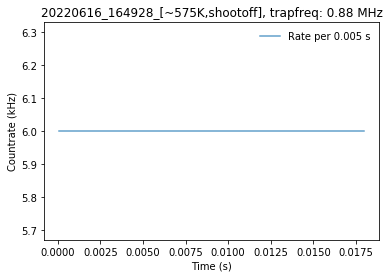

In [67]:
plt.plot(ratesx[:-1], rates/1e3, label = 'Rate per %.2g s'%(ratTime), alpha =0.7)
# movingav_time = 20
# movingav_ix = int(movingav_time/ratTime)
# plt.plot(moving_average(ratesx[:-1], movingav_ix),moving_average(rates/1e3, movingav_ix), alpha =0.7)
plt.xlabel('Time (s)')
plt.ylabel('Countrate (kHz)')
plt.legend(loc=0, frameon=False)
plt.title(runID+'_[~575K,shootoff], trapfreq: 0.88 MHz')
# plt.xlim(51.75,52)
plt.savefig('%s_Countrate.pdf'%runID, dpi=500)
plt.savefig('%s_Countrate.png'%runID, dpi=500)
# print np.mean(rates)/1e3,'kHz +/-', np.std(rates)/len(rates)

## Plot Histogram of countrates, and Skew&Kurtosis

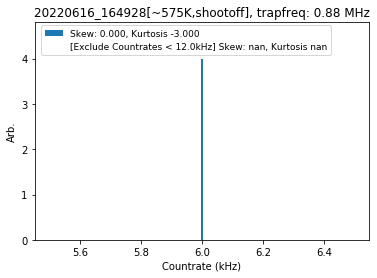

In [68]:
bins = 165
plt.hist(rates/1e3, bins, label = 'Skew: %.3f, Kurtosis %.3f'%(skew(rates), 
                                                          kurtosis(rates)))
exclude = 12000
ratsy, ratsx, ratsfaces = plt.hist(rates/1e3, bins, label = '[Exclude Countrates < %skHz] Skew: %.3f, Kurtosis %.3f'%(exclude/1e3, skew(rates[rates>exclude]), 
                                                          kurtosis(rates[rates>exclude])), alpha = 0)
# plt.yscale('log')
plt.title(runID+'[~575K,shootoff], trapfreq: 0.88 MHz')
plt.ylim(0, np.max(ratsy)*1.2)
plt.legend(loc=[0.02,0.85], frameon=True, fontsize = 9)
plt.xlabel('Countrate (kHz)')
plt.ylabel('Arb.')
plt.savefig('%s_Countrate_hist.pdf'%runID, dpi=500)
plt.savefig('%s_Countrate_hist.png'%runID, dpi=500)

In [162]:
testrand =  np.random.rand(int(1e6))*20

difftimes = np.arange(500e-6,400000e-6,800e-6)
diffskew = np.zeros(len(difftimes))
for i in tqdm(range(0, len(difftimes))):
    ratesy, ratesx, ratestmp = rebinDat(difftimes[i],testrand)
    diffskew[i] = skew(ratestmp)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]Exception KeyError: KeyError(<weakref at 000000000D2569A8; to 'tqdm' at 0000000010AC68D0>,) in <bound method tqdm.__del__ of   0%|                                                                                          | 0/500 [00:00<?, ?it/s]> ignored


ValueError: `bins` must be positive, when an integer

In [163]:
difftimes = np.arange(500e-6,400000e-6,800e-6)
diffskew = np.zeros(len(difftimes))
for i in tqdm(range(0, len(difftimes))):
    ratesy, ratesx, ratestmp = rebinDat(difftimes[i],pulses_time)
    diffskew[i] = skew(ratestmp)
    


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.13it/s]


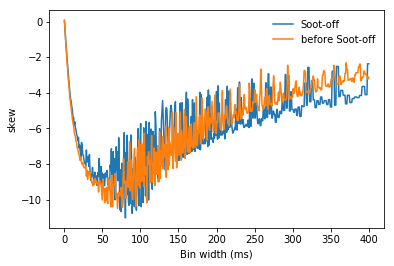

In [168]:
difftimes2, diffskew2 = difftimes, diffskew
plt.plot(difftimes1*1e3, diffskew1, label='Soot-off')

plt.plot(difftimes2*1e3, diffskew2, label='before Soot-off')
plt.legend(loc=0, frameon=False)
plt.xlabel('Bin width (ms)')
plt.ylabel('skew')


plt.savefig('Skew.pdf', dpi=500)
plt.savefig('Skew.png', dpi=500)

In [5]:
import numpy as np
a = np.arange(1,4)
b = np.zeros((2,3))
a

array([1, 2, 3])

In [6]:
b

array([[0., 0., 0.],
       [0., 0., 0.]])

In [7]:
b-a

array([[-1., -2., -3.],
       [-1., -2., -3.]])